# Tutorial # 1 -- RT through a homogeneous, static sphere

In this first tutorial, we compute RT of radiation emitted by a central source and through a homogeneous sphere filled with gas and dust. The model is defined by a few parameters described below.

The number densities of scatterers ($n_{\rm scat}$) and dust ($n_d$) are uniform within the sphere of radius $R_{\rm sphere}$. They are defined by setting a value for the column density from the central source to the edge of the sphere: $N_{X} = n_{X}\times R_{\rm sphere}$, for each species $X$. Numerically, the sphere covers the full computational domain ...



`ColumnDensity_cgs` is the column density of the scattering species (in cm^-2). (defined here: [CGM model](#CGM_model))


In [1]:
# First a few necessary setups
RascasDir = '../../../rascas-SaasFee/'  # Where you have your rascas clone.
ExperimentDir = './'  # where the RASCAS run will happen (and where param file will be written). 

# use a parallel environment or not
useMPI = True

# include rascas/py in the path for imports 
import sys
sys.path.append("../../py/")
# imports from rascas/py
import write_param_files as wpf
import jphot as jp
import lya_utils as lya

# 
import os
import matplotlib.pyplot as plt
import numpy as np

# Units ... TBC... 
import astropy.units as u
from astropy.constants import c

# 1. Definition of parameters
Parameters need to be provided for different sections of the code. We build a list of sections in the variable `Parameters` and fill it up.

In [2]:
Parameters = []  # initialise a list of parameter sections

## 1.1. Parameters describing the gas and dust distribution

### 1.1.1. Computational domain
The computational domain is the domain within which the photon packets propagate. The RT computation stops when all photon packets have escaped this domain (or been absorbed by dust). 

In [3]:
section = 'CreateDomDump'
params = {
    'DomDumpDir'       : ExperimentDir,
    'idealised_models' : 'T',
    'comput_dom_type'  : 'sphere',
    'comput_dom_pos'   : '0.5,0.5,0.5',
    'comput_dom_rsp'   : '0.4'
}
Parameters.append(wpf.param_section(section,params))

### 1.1.2.  Mesh properties (refinement and max resolution)

In [4]:
section = 'mesh'
params = {
    'verbose'       : 'T',
    'refine_lmax'   : '7',   # no need for refinement with a homogeneous medium ... 
    'refine_err_grad_d'  : '0.1',
    'refine_err_grad_v'  : '-1',
    'refine_dv_over_vth' : 'F',
}
Parameters.append(wpf.param_section(section,params))

### 1.1.3. Gas composition 

In [5]:
section = 'gas_composition'
params = {
    'nscatterer'       : '2', #'1',
    'scatterer_names'  : 'SiII-1190, SiII-1193', #'SiII-1260',
    'atomic_data_dir'   : "%s/ions_parameters/"%RascasDir,
    'ignoreDust': 'T'
}
Parameters.append(wpf.param_section(section,params))

### 1.1.4. Properties of dust

In [6]:
section = 'dust'
params = {
    'albedo':0.32,
    'g_dust':0.73,
    'dust_model':'SMC'
}
Parameters.append(wpf.param_section(section,params))

### 1.1.5. CGM model parameter <a id="CGM_model"></a>

In [7]:
section = 'IdealisedModel'
params ={
    'ColumnDensity_cgs':'1e19',   # [cm^-2]
    'boxsize_cm': '1e22',   # [cm]
    'Radius_boxUnits': '0.4',         # [in units of box size]
    'Temperature':'1e4',
    'TurbulentVelocity_kms':'30'
}
Parameters.append(wpf.param_section(section,params))

## 1.2. Parameters describing the source

In [8]:
section = 'PhotonsFromSourceModel'
params ={
    'outputfile' : '%s/ppic.dat'%ExperimentDir,
    'source_pos' : '0.5,0.5,0.5',
    'source_vel' : '0,0,0',        # cm/s
    'source_type': 'pointlike',
    'spec_type'  : 'PowLaw',
    'spec_powlaw_lmin_Ang' : '1189',#'1259',
    'spec_powlaw_lmax_Ang' : '1198', #'1266',
    'spec_powlaw_beta'     : '-2.0',
    'nPhotonPackets'       : '100000'
}
Parameters.append(wpf.param_section(section,params))

## 1.3. Parameters the RT computation

### 1.3.1. Numerical details

In [9]:
if useMPI:
    section = 'rascas' 
else:
    section = 'rascas-serial' 

params ={
    'verbose':'T',
    'DomDumpDir':ExperimentDir,
    'PhotonICFile':'%s/ppic.dat'%ExperimentDir,
    'fileout':'%s/result.dat'%ExperimentDir,
    'nbundle':'1000'
}
Parameters.append(wpf.param_section(section,params))

section='worker'
params={'verbose':'T'}
Parameters.append(wpf.param_section(section,params))

### 1.3.1. Peeling-off mocks

In [10]:
# Here we need to specify the properties of the mocks we wish to construct, in terms of aim (coords 
# of target and direction of observation) and in terms of observation (photometry, spectroscopy, 
# imaging, 3D spectroscopy). This is done through parameters which need to be written to a file. 

# We start by setting up one pointing and defining the observations for it. 
target_position = np.array([0.5,0.5,0.5])  # aim for the center of the box (all in box units here... )
kobs = np.array([0,1,0])  # observe along the y direction (make sure k is normalised)

# now, let's add a spectroscopic observation
npix = 200 # the nb of wavelength bins
aperture = 1. # the radius of the circular aperture within which photon packets are collected (in box-size units)
lambda_min = 1189  # min wavelength (Angstrom)
lambda_max = 1198  # max wavelength (Angstrom)
spec = wpf.specParams(npix,aperture,lambda_min,lambda_max)

# let's make an image as well ... 
npix = 200 # nb of pixels on a side
size = 1.   # size of the image (side)
image = wpf.imageParams(npix,size)

# define the object containing all the above information
p = wpf.pointing(kobs,target_position,spec=spec,image=image)

# and write it into some file 
mock_params_file = '%s/mock_param_file.txt'%ExperimentDir
f = open(mock_params_file,'w')
p.write(f)
f.close()

section='mock'
params = {
    'nDirections':'1', 
    'mock_parameter_file':'%s'%mock_params_file,
    'mock_outputfilename':'%s/mock'%ExperimentDir
}
Parameters.append(wpf.param_section(section,params))

# 2.  Write parameter file and run the codes

In [11]:
# write parameter list to a file 
wpf.write_parameter_file('params.cfg',Parameters)

## 2.1 create mesh and visualize it

Execute the following cell in order run the executable `CreateDomDumpAMRModel` which generates the adaptive mesh containing the model. This will generate a few files in the `ExperimentDir`, including a log file `CreateDomDumpAMRModel.log`, the `.mesh` file (which has the data) and some `.dom` files which describe different domains. 

In [12]:
# run CreateDomDumpAMRModel
cmd = "./CreateDomDumpAMRModel params.cfg > CreateDomDumpAMRModel.log"
error = os.system(cmd)
if error != 0:
    print('Something went wrong...')
    print('-> check file CreateDomDumpAMRModel.log or message below for more info')

In [13]:
# visualise the mesh 



## 2.2 create the photon packets

In [14]:
# run PhotonsFromSourceModel
cmd = "./PhotonsFromSourceModel params.cfg > PhotonsFromSourceModel.log"
error = os.system(cmd)
if error != 0:
    print('Something went wrong...')
    print('-> check file PhotonsFromSourceModel.log or message below for more info')

Text(0, 0.5, 'Nb of photon packets per Angstrom')

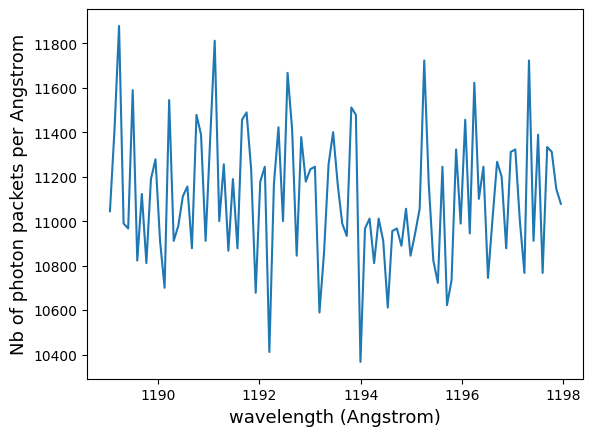

In [15]:
# have a look at the photon packets
p = jp.photonlist('ppic.dat','result.dat',load=False)
p.load_ic()
lint,sint = p.spectrum(frame='ic',Flambda=False,nbins=100)
plt.plot(lint,sint)
plt.xlabel('wavelength (Angstrom)',fontsize=13)
plt.ylabel('Nb of photon packets per Angstrom',fontsize=13)

## 2.3 Run the radiative transfer

In [16]:
# run RASCAS 
if useMPI:
    cmd = "time mpirun ./rascas params.cfg > rascas.log"
else:
    cmd = "time ./rascas-serial params.cfg > rascas.log"
error = os.system(cmd)
if error != 0:
    print('Something went wrong...')
    print('-> check file rascas.log or message below for more info')


real	0m0.820s
user	0m3.478s
sys	0m0.218s


# 3. Plot the results 

## 3.1. results from photon packets

### 3.1.1. Spectrum (angle-averaged and spatially integrated)

In [17]:
# load the results of the RASCAS experiment
p = jp.photonlist('ppic.dat','result.dat')

In [18]:
# get the observed spectrum
lobs,sobs = p.spectrum(frame='obs',nbins=300)

# get the intrinsic spectrum
lint,sint = p.spectrum(frame='ic',nbins=300)

In [19]:
# normalise spectra to the median value of the intrinsic spectrum
continuum = np.median(sint)
sobs = sobs / continuum
sint = sint / continuum

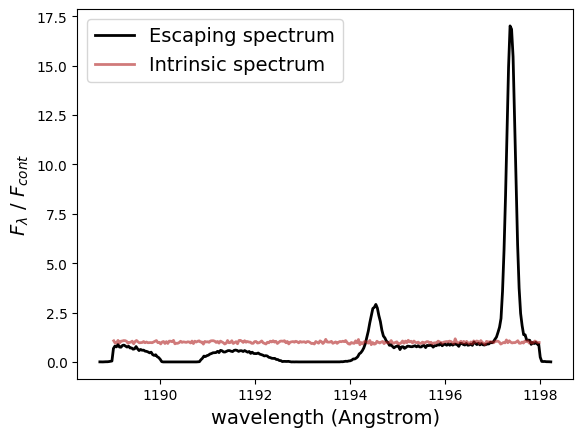

In [20]:
# plot spectra 
plt.plot(lobs,sobs,label='Escaping spectrum',lw=2,ls='-',c='k')
plt.plot(lint,sint,alpha=0.6,label='Intrinsic spectrum',lw=2,ls='-',c='firebrick')
plt.legend(fontsize=14)
plt.xlabel('wavelength (Angstrom)',fontsize=14)
plt.ylabel(r'$F_\lambda\ /\ F_{cont}$',fontsize=14)
plt.show()

### 3.1.2. Surface-brightness map and profile (angle-averaged)

### 3.1.3. Spatially resolved spectrum (angle-averaged)

## 3.2. Peeling off results 

In [21]:
from mocks import mockobs
m = mockobs('./','mock','./ppic.dat',load_spectrum=True,load_image=True)

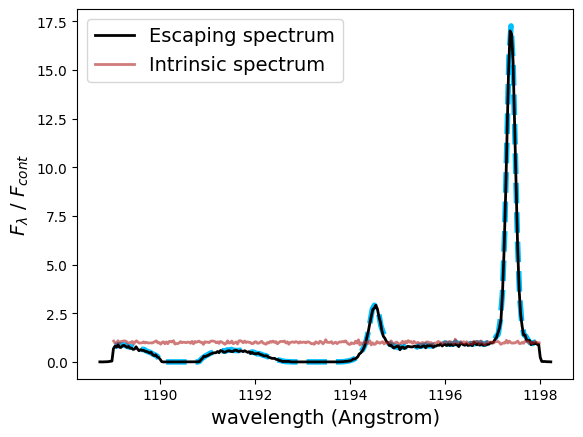

In [22]:
plt.figure()
plt.plot(m.spec_lbda_Angstrom,m.spec/continuum,lw=4,ls='--',c='deepskyblue')
plt.plot(lobs,sobs,label='Escaping spectrum',lw=2,ls='-',c='k')
plt.plot(lint,sint,alpha=0.6,label='Intrinsic spectrum',lw=2,ls='-',c='firebrick')
plt.legend(fontsize=14)
plt.xlabel('wavelength (Angstrom)',fontsize=14)
plt.ylabel(r'$F_\lambda\ /\ F_{cont}$',fontsize=14)
plt.show()

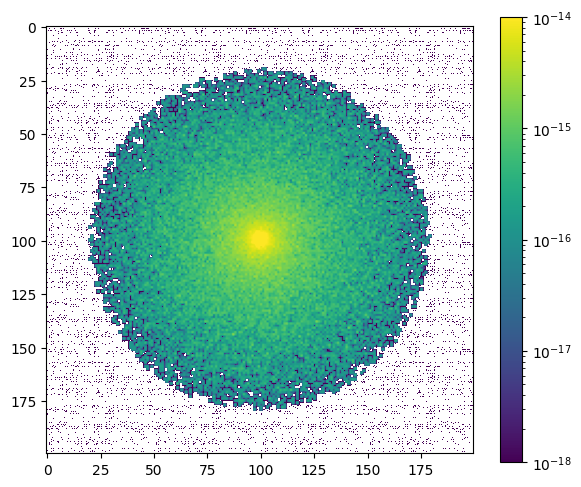

In [23]:
m.show_image(smooth=False,vmin=1e-18,vmax=1e-14) 